In [150]:
cd /home

/home


# Astromer I vs Astromer II

In [151]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import os

from sklearn.metrics import r2_score, mean_squared_error
from presentation.experiments.utils import get_clf_summary
from src.utils import get_metrics

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**WARNING**: This notebook was made to visualize classification results only. 

All the following blocks assume you already ran the script `./presentation/experiments/astromer_{1/2}/script.py`.

The directory looks like: 
- `presentation`
    - `astromer_1/results/<experiment_folder>`
        - `finetuning`
        - `classification`
        - `pretraining`
    - `astromer_2/results/<experiment_folder>`
        - `finetuning`
        - `classification`
        - `pretraining`

In [156]:
folders = [
    './presentation/experiments/astromer_1/results/paper_clean/2023-09-09_20-28-14/',
    './presentation/experiments/astromer_2/results/paper/2023-09-10_02-15-21/'
]
tags = ['Astromer I', 'Astromer II']

In [160]:
summary = []
for folder, tag in zip(folders, tags):
    partial = get_clf_summary(folder, tag)
    summary.append(partial)
    
summary = pd.concat(summary, axis=0)

In [161]:
summary.columns

Index(['exp_name', 'data', 'checkpoint', 'gpu', 'debug', 'encoder_mode',
       'num_layers', 'num_heads', 'head_dim', 'pe_dim', 'pe_base', 'pe_exp',
       'mixer', 'dropout', 'avg_layers', 'lr', 'bs', 'patience', 'num_epochs',
       'window_size', 'probed', 'rs', 'clf_val_acc', 'clf_val_loss',
       'clf_test_precision', 'clf_test_recall', 'clf_test_f1', 'clf_test_acc',
       'tag', 'clf_name', 'fold', 'downstream_data', 'samples_per_class',
       'nsp_prob', 'rmse_factor'],
      dtype='object')

alcock
atlas


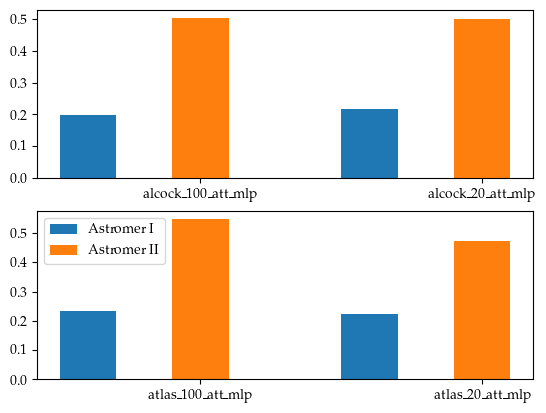

In [162]:
fig, axes = plt.subplots(2, 1)
count = 0
delta = 0.2
for downstream_data, frame_0 in summary.groupby('downstream_data'):
    print(downstream_data)
    shift = 0
    for tag, frame_1 in frame_0.groupby('tag'):
        x_tickslab, mean_values, std_values = [], [], []
        for (spc, clfname), frame_2 in frame_1.groupby(['samples_per_class', 'clf_name']):
            f1_values = frame_2['clf_val_acc'].astype(float)
            x_tickslab.append('{}_{}_{}'.format(downstream_data, spc, clf_name))
            mean_values.append(f1_values.mean())
            std_values.append(f1_values.std())
        
        x_range = np.arange(len(mean_values))+shift
        axes[count].bar(x_range, mean_values, width=delta, label=tag)
        axes[count].set_xticks(x_range)
        axes[count].set_xticklabels(x_tickslab, rotation=0)
        shift+=delta*2
    
    count+=1
axes[-1].legend()